In [2]:
import pandas as pd
import os, os.path
import config as cfg
from glob import glob
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
# from pydub import AudioSegment

/home/fumchin/miniconda3/envs/bsed/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
review_saved_path = os.path.join("/home/fumchin/data/bsed_20/dataset", "review")
bird_list = cfg.bird_list


dataset_root = cfg.dataset_root
annotation_path = os.path.join(dataset_root, "annotation")
recording_path = os.path.join(dataset_root, "wav")
domain_name_list = [name for name in os.listdir(annotation_path) if "Recording" in name]

In [4]:
all_df = None
for domain_index, domain_name in enumerate(domain_name_list):
    current_annotation_path = os.path.join(annotation_path, domain_name)
    current_recording_path = os.path.join(recording_path, domain_name)
    
    audio_files_path_list = glob(os.path.join(current_recording_path, "*.wav"))
    # iterate through all wave files in the domain folder
    for file_index, current_audio_files_path in enumerate(audio_files_path_list):
        wav_name = os.path.splitext(os.path.basename(current_audio_files_path))[0]
        current_annotation_file_path = glob(os.path.join(current_annotation_path, wav_name + "*.txt"))[0]
        
        annotation_df = pd.read_csv(current_annotation_file_path, sep="\t")
        annotation_df = annotation_df[['Species', 'Begin Time (s)', 'End Time (s)']]
        annotation_df['filename'] = wav_name
        annotation_df = annotation_df[annotation_df['Species'].isin(bird_list)]
        
        if ((domain_index==0) & (file_index == 0)):
            all_df = annotation_df
        else:
            all_df = pd.concat([all_df, annotation_df], axis=0, ignore_index=True)
all_df.head()
all_df['duration'] = all_df['End Time (s)'] - all_df['Begin Time (s)']
# print(len((all_df.index)))

[Text(0, 0, '0'),
 Text(0, 0, '11'),
 Text(0, 0, '42'),
 Text(0, 0, '134'),
 Text(0, 0, '286'),
 Text(0, 0, '486'),
 Text(0, 0, '674'),
 Text(0, 0, '746'),
 Text(0, 0, '711'),
 Text(0, 0, '428'),
 Text(0, 0, '388'),
 Text(0, 0, '288'),
 Text(0, 0, '222'),
 Text(0, 0, '218'),
 Text(0, 0, '240'),
 Text(0, 0, '253'),
 Text(0, 0, '300'),
 Text(0, 0, '357'),
 Text(0, 0, '372'),
 Text(0, 0, '446')]

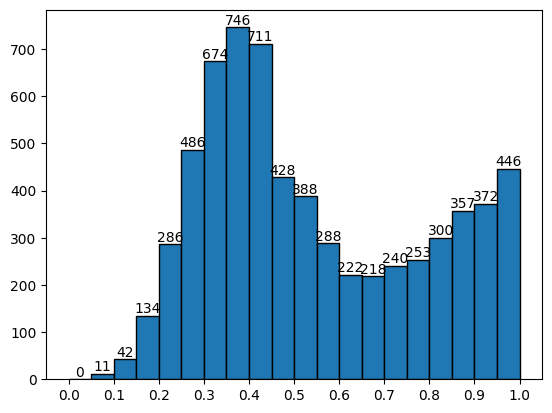

In [5]:

max = 1
step = 0.05
result_df = all_df[all_df['duration'] < max]
bin = np.arange(0.0, max + step, step)
x_axis = np.arange(0.0, max + 2*step, 2*step)
# print(x_axis)
# all_df['duration'].plot.hist(bins=bin, edgecolor='black', xticks=x_axis)

counts, edges, bars = plt.hist(result_df['duration'], bins=bin, edgecolor='black')
plt.xticks(x_axis)
plt.bar_label(bars)

[Text(0, 0, '5548'),
 Text(0, 0, '1729'),
 Text(0, 0, '493'),
 Text(0, 0, '445'),
 Text(0, 0, '178'),
 Text(0, 0, '142'),
 Text(0, 0, '65'),
 Text(0, 0, '46'),
 Text(0, 0, '16'),
 Text(0, 0, '18'),
 Text(0, 0, '13'),
 Text(0, 0, '12'),
 Text(0, 0, '9'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '6'),
 Text(0, 0, '6'),
 Text(0, 0, '3')]

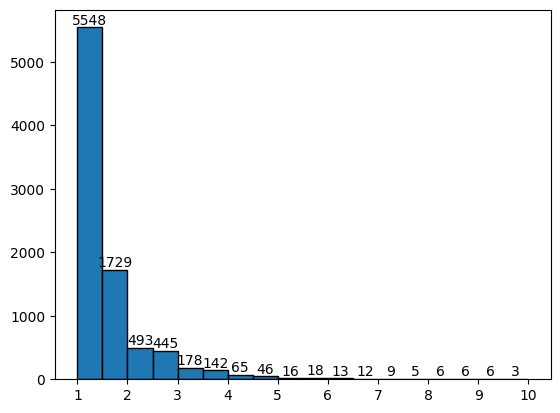

In [6]:
min = 1
max = 10
step = 0.5
result_df = all_df[all_df['duration'] < max]
bin = np.arange(min, max + step, step)
x_axis = np.arange(min, max + 2*step, 2*step)
# print(x_axis)
# all_df['duration'].plot.hist(bins=bin, edgecolor='black', xticks=x_axis)

counts, edges, bars = plt.hist(result_df['duration'], bins=bin, edgecolor='black')
plt.xticks(x_axis)
plt.bar_label(bars)

#### 計算 < 0.2 類別的數量和比例

In [7]:
data = all_df
result = data.groupby('Species').agg({'duration': [('total_count', 'count'), ('short_count', lambda x: (x < 0.25).sum())]})

# 计算duration小于0.25的数量占比
result['short_ratio'] = 100*result['duration']['short_count'] / result['duration']['total_count']

# 输出结果
print(result)

           duration             short_ratio
        total_count short_count            
Species                                    
AMCR            534          12    2.247191
AMRE            274           0    0.000000
BAWW            142           0    0.000000
BCCH           1262         100    7.923930
BGGN            320          19    5.937500
BHCO            176          13    7.386364
BHVI            174          16    9.195402
BLJA            519           4    0.770713
BTNW           1058           0    0.000000
COYE            365           2    0.547945
EATO           5238         217    4.142803
HETH            162           0    0.000000
KEWA            194           0    0.000000
NOCA            884           6    0.678733
OVEN            404           1    0.247525
RBWO            145           6    4.137931
REVI            592          45    7.601351
SCTA            290           3    1.034483
TUTI            885          13    1.468927
WOTH           1826          16 

#### merge間隔小於0.15的同類別event

In [8]:
df = all_df
grouped = df.groupby(['filename', 'Species'])
new_df = pd.DataFrame(columns=df.columns)
for key, item in grouped:
    temp = grouped.get_group(key)
    temp = temp.sort_values(by=['Begin Time (s)'])
    for i, row in temp.iterrows():
        try:
            mask = ((abs(temp['End Time (s)'] - row['Begin Time (s)']) < 0.15) & ((temp['Begin Time (s)'] - row['Begin Time (s)']) != 0))
            if(temp[mask].empty == False):
                # merge two rows
                # print(temp[mask])
                # print(row.to_frame().T)
                merged = temp[mask].copy()
                merged['End Time (s)'] = row['End Time (s)']
                # merged = pd.concat([temp[mask], row.to_frame().T], axis=0, ignore_index=True)
                temp = temp.drop([i, temp[mask].index.tolist()[0]])
                temp = pd.concat([temp, merged], axis=0)
                temp = temp.sort_values(by=['Begin Time (s)'])
                # print(temp)
                # break
        except:
            break
    new_df = pd.concat([new_df, temp], axis=0, ignore_index=True)

new_df = new_df.reset_index(drop=True)

#### merge overlapping

In [14]:
df = all_df
grouped = df.groupby(['filename', 'Species'])
new_df = pd.DataFrame(columns=df.columns)
for key, item in grouped:
    temp = grouped.get_group(key)
    temp = temp.sort_values(by=['Begin Time (s)'])
    for i in range(temp.shape[0] - 1):
        try:
            for j in range(i + 1, temp.shape[0]):
                row_i = temp.iloc[i]
                row_j = temp.iloc[j]
                try:
                    if(row_i['End Time (s)'] > row_j['End Time (s)']):
                        temp = temp.drop([j])
                except:
                    break
            new_df = pd.concat([new_df, temp], axis=0, ignore_index=True)
        except:
            break
new_df = new_df.reset_index(drop=True)

In [15]:
df = new_df
grouped = df.groupby(['filename', 'Species'])
new_df = pd.DataFrame(columns=df.columns)
for key, item in grouped:
    temp = grouped.get_group(key)
    temp = temp.sort_values(by=['Begin Time (s)'])
    for i in range(temp.shape[0] - 1):
        try:
            for j in range(i + 1, temp.shape[0]):
                
                row_i = temp.iloc[i]
                row_j = temp.iloc[j]
                try:
                    if(row_i['End Time (s)'] > row_j['End Time (s)']):
                        print(row_i.to_frame().T)
                        print(row_j.to_frame().T)
                        # temp = temp.drop([j])
                except:
                    break
            # new_df = pd.concat([new_df, temp], axis=0, ignore_index=True)
        except:
            break
# new_df = new_df.reset_index(drop=True)

In [11]:
from glob import glob
import os, os.path
import pandas as pd
import config as cfg
# analysis data
train_unlabeled_annotation_path = "/home/fumchin/data/bsed_20/dataset/ENA/train_unlabeled_preprocess_quarter_02_015/annotation"
train_weakly_labeled_annotation_path = "/home/fumchin/data/bsed_20/dataset/ENA/train_weak_preprocess_quarter_02_015/annotation"
validation_annotation_path = "/home/fumchin/data/bsed_20/dataset/ENA/val_preprocess_quarter_02_015/annotation"

annotation_path_list = [train_unlabeled_annotation_path, train_weakly_labeled_annotation_path]
for annotation_path in annotation_path_list:
    annotation_file_list = glob(os.path.join(annotation_path, "*.txt"))
    df_full = None
    for file_count ,annotation_file in enumerate(annotation_file_list):
        df = pd.read_csv(annotation_file, sep="\t")
        df = df[['event_label', 'onset', 'offset']]
        df = df[df['event_label'].isin(cfg.bird_list)]
        if file_count == 0:
            df_full = df
        else:
            df_full = pd.concat([df_full, df], axis=0, ignore_index=True)
        # group by Species and count the number of each species

    grouped_df = df_full.groupby('event_label').count()
    print(grouped_df)
    
        
        

             onset  offset
event_label               
AMCR           256     256
AMRE           104     104
BAWW            57      57
BCCH           393     393
BGGN           122     122
BHCO            60      60
BHVI            59      59
BLJA           188     188
BTNW           400     400
COYE           151     151
EATO          1878    1878
HETH            79      79
KEWA            77      77
NOCA           330     330
OVEN           176     176
RBWO            60      60
REVI           224     224
SCTA           109     109
TUTI           324     324
WOTH           693     693
             onset  offset
event_label               
AMCR            77      77
AMRE            37      37
BAWW            21      21
BCCH           154     154
BGGN            49      49
BHCO            18      18
BHVI            21      21
BLJA            77      77
BTNW           154     154
COYE            36      36
EATO           613     613
HETH            17      17
KEWA            25      25
N